# Preprocessing of Project-level TCGA CNA Files

In [1]:
import pandas as pd
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn as sns
import mygene
import h5py
import os, sys, math
import umap
from functools import reduce

sys.path.append(os.path.abspath('../preprocessing/'))
import preprocessing_utils as utils

bestSplit = lambda x: (round(math.sqrt(x)), math.ceil(x / round(math.sqrt(x))))

%matplotlib inline

In [17]:
NORMALIZE_FOR_GENE_LENGTH = True

gencode_annotation_path = '../../data/pancancer/gencode/gencode.v28.basic.annotation.gff3'
cna_base_dir = '../../data/pancancer/TCGA/mutation/CNA/'
ultra_mutated_samples_path = '../../data/pancancer/TCGA/mutation/ultramutated_tumor_ids'

## Step 1: Compute Exonic Gene Length for all Genes

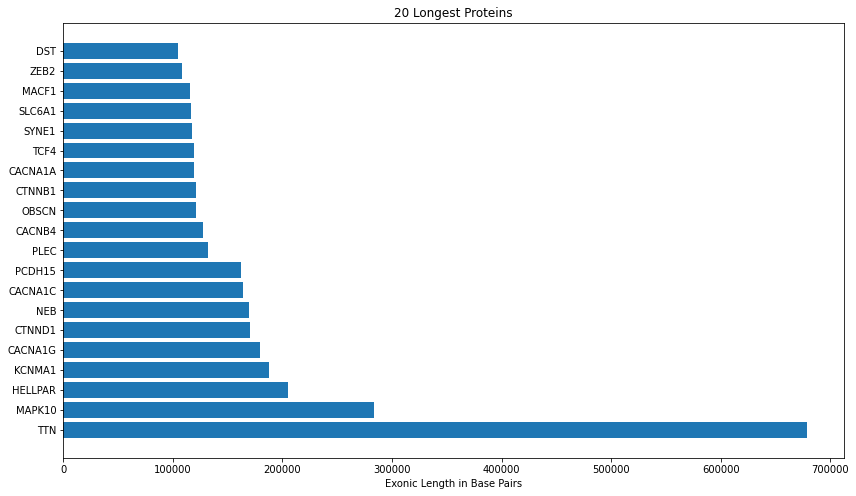

In [18]:
if NORMALIZE_FOR_GENE_LENGTH:
    annotation_gencode = pd.read_csv(gencode_annotation_path,
                                 comment='#', sep='\t', skiprows=7,header=None,
                                 names=['chr', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attr']
                                )
    # derive length of all exons
    annotation_gencode = annotation_gencode[annotation_gencode.type == 'exon']
    annotation_gencode['length'] = np.abs(annotation_gencode.end - annotation_gencode.start)
    # extract the gene name for each exon
    def get_hugo_symbol(row):
        s = row.attr
        for elem in s.split(';'):
            if elem.startswith('gene_name'):
                return elem.split('=')[1].strip()
        return None
    annotation_gencode['Hugo_Symbol'] = annotation_gencode.apply(get_hugo_symbol, axis=1)
    # add length of exons together for each gene
    exonic_gene_lengths = annotation_gencode.groupby('Hugo_Symbol').length.sum()

    # plot the longest proteins at the end
    fig = plt.figure(figsize=(14, 8))
    plt.barh(y = range(20), width=exonic_gene_lengths.sort_values(ascending=False).head(20), tick_label=exonic_gene_lengths.sort_values(ascending=False).head(20).index)
    plt.xlabel('Exonic Length in Base Pairs')
    plt.title('20 Longest Proteins')

## Step 2: Load CNAs from Disk and Preprocess
In this step, we load the CNAs from TCGA per cancer type/study. We next normalize for gene length (if requested) and then average across samples.

In [21]:
def process_cna_for_ctype(fname, gene_lengths=None):
    # load data for cancer type
    gene_sample_matrix = pd.read_csv(fname, sep='\t')
    # remove the isoform from ensembl IDs
    gene_sample_matrix.set_index(gene_sample_matrix['Gene Symbol'].str.split('.').str[0], inplace=True)
    # drop uninformative columns
    gene_sample_matrix.drop(['Gene Symbol', 'Gene ID', 'Cytoband'], axis=1, inplace=True)
    if not gene_lengths is None:
        bpmr = gene_sample_matrix.abs().sum() / float(gene_lengths.sum()) # mutation rate per base per patient (vector)
        print (bpmr.mean())
        expected_mutation_rates = pd.DataFrame(np.matlib.repmat(bpmr, gene_lengths.shape[0], 1) * gene_lengths.values.reshape(-1, 1),
                                               index=gene_lengths.index,
                                               columns=bpmr.index
                                              ) # expected mutation frequency per gene and patient
        denom = 1 + expected_mutation_rates.reindex_like(gene_sample_matrix).fillna(expected_mutation_rates.median(axis=0))
        normalized_gene_sample_matrix = gene_sample_matrix.abs() / denom
        cna_mean_matrix = normalized_gene_sample_matrix.mean(axis=1)
    else:
        # compute average of absolute CNAs (no cancelling out)
        cna_mean_matrix = gene_sample_matrix.abs().mean(axis=1)
    # get cancer type from file name
    ctype = os.path.basename(fname).split('.')[0].strip()
    # rename series to cancer type
    cna_mean_matrix.rename(ctype, inplace=True)

    return cna_mean_matrix, ctype

cna_all_matrices = []
cna_ctypes = []
for dname in os.listdir(cna_base_dir):
    ctype_dir = os.path.join(cna_base_dir, dname)
    if os.path.isdir(ctype_dir):
        for cna_gene_scores in os.listdir(ctype_dir):
            if cna_gene_scores.endswith('focal_score_by_genes.txt'):
                if NORMALIZE_FOR_GENE_LENGTH:
                    avg_cna, ctype = process_cna_for_ctype(os.path.join(ctype_dir, cna_gene_scores),
                                                           gene_lengths=exonic_gene_lengths)
                else:
                    avg_cna, ctype = process_cna_for_ctype(os.path.join(ctype_dir, cna_gene_scores), gene_lengths=None)
                cna_all_matrices.append(avg_cna)
                cna_ctypes.append(ctype)
                print ("Processed {}".format(ctype))

4.095333275757464e-06
Processed PRAD
6.477790068766598e-06
Processed LIHC
1.0517950324668259e-05
Processed LUSC
9.681745411548166e-06
Processed BLCA
6.557614652885231e-06
Processed CESC
1.2031022330974295e-06
Processed KIRP
9.865853516213125e-06
Processed BRCA
7.720146798420783e-06
Processed STAD
6.593935821214601e-06
Processed HNSC
5.006320353770443e-06
Processed READ
6.377408905760918e-06
Processed UCEC
7.849189345944306e-06
Processed LUAD
1.7644882185580586e-07
Processed THCA
3.5685833097423506e-06
Processed COAD
1.999203630805188e-06
Processed KIRC
1.1196488330553018e-05
Processed ESCA


## Step 3: Merge and Provide Gene Symbols

In [12]:
cna_mean_matrix2 = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), cna_all_matrices)

In [25]:
cna_mean_matrix2.mean(axis=1).sort_values(ascending=False)

Gene Symbol
ENSG00000177694    0.195310
ENSG00000186153    0.173605
ENSG00000168702    0.157173
ENSG00000145012    0.155726
ENSG00000264545    0.154464
                     ...   
ENSG00000183035    0.021962
ENSG00000153779    0.021880
ENSG00000147138    0.021800
ENSG00000147183    0.021416
ENSG00000102271    0.021127
Length: 19729, dtype: float64

In [14]:
cna_mean_matrix2[cna_mean_matrix2.index == 'ENSG00000141510'].T.sort_values(by='ENSG00000141510', ascending=False)

Gene Symbol,ENSG00000141510
PRAD,0.181275
LIHC,0.097625
UCEC,0.065693
BLCA,0.057831
BRCA,0.056962
ESCA,0.054054
LUAD,0.050450
STAD,0.045455
HNSC,0.041825
LUSC,0.036260


In [26]:
cna_mean_matrix[cna_mean_matrix.index == 'ENSG00000141510'].T.sort_values(by='ENSG00000141510', ascending=False)
cna_mean_matrix.mean(axis=1).sort_values(ascending=False)

Gene Symbol
ENSG00000177694    0.192954
ENSG00000186153    0.171760
ENSG00000168702    0.155265
ENSG00000145012    0.153694
ENSG00000172264    0.152814
                     ...   
ENSG00000183035    0.021589
ENSG00000153779    0.021508
ENSG00000147138    0.021429
ENSG00000147183    0.021066
ENSG00000102271    0.020768
Length: 19729, dtype: float64

In [52]:
cna_mean_matrix = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), cna_all_matrices)
# get gene symbols
ensembl_symbol_map = utils.get_symbols_from_ensembl(cna_mean_matrix.index)
cna_mean_with_names = cna_mean_matrix.join(ensembl_symbol_map)
cna_mean_with_names.dropna(axis=0, inplace=True)
cna_mean_with_names.set_index('Symbol', inplace=True)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-19729...done.
Finished.
280 input query terms found no hit:
	['ENSG00000273547', 'ENSG00000278566', 'ENSG00000279244', 'ENSG00000237847', 'ENSG00000268991', 'ENS


In [55]:
cna_mean_with_names[cna_mean_with_names.index == 'SOX2'].T.sort_values(by='SOX2', ascending=False)

Symbol,SOX2
LUSC,0.503304
ESCA,0.314683
HNSC,0.267196
CESC,0.199848
UCEC,0.144982
BRCA,0.135574
STAD,0.131980
BLCA,0.113631
LUAD,0.106456
LIHC,0.075662


## Step 4: Write to Disk

In [67]:
cna_mean_with_names = cna_mean_with_names[~cna_mean_with_names.index.duplicated(keep='first')]
cna_mean_with_names.to_csv('../../data/pancancer/TCGA/mutation/CNA_mean_TCGA.tsv', sep='\t')